# DoS detection integrating entropy maths with Bi-lstm

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Concatenate, Input
from keras.models import Model

ModuleNotFoundError: No module named 'keras'

In [ ]:
# Loading the dataset
df = pd.read_csv('/kaggle/input/network-traffic-for-dos-detection/dataset.csv')

# Print columns of the DataFrame
print("Columns after loading dataset:")
print(df.columns)

Columns after loading dataset:
Index(['Id', 'IP', 'bot', 'FunctionId', 'functionTrigger', 'timestamp',
       'SubmitTime', 'RTT', 'InvocationDelay', 'ResponseDelay',
       'FunctionDuration', 'ActiveFunctionsAtRequest',
       'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu',
       'vmcategory', 'vmcorecountbucket', 'vmmemorybucket'],
      dtype='object')


In [ ]:
def calculate_entropy(feature_values):
    # Convert float64 data to integer by rounding
    feature_values = np.round(feature_values).astype(int)
    
    # Count occurrences of each unique value in the feature
    value_counts = np.bincount(feature_values)
    
    # Calculate probability of each unique value
    probabilities = value_counts / len(feature_values)
    
    # Calculate entropy
    entropy = -np.sum(probabilities * np.log2(probabilities + 1e-10))  # Adding a small value to avoid log(0)
    
    return entropy

In [ ]:
# Function to prepare dataset and calculate entropy
def prepare_dataset(df):
    # Select relevant features
    selected_features = ['RTT', 'InvocationDelay', 'ResponseDelay', 'FunctionDuration', 'ActiveFunctionsAtRequest', 
                         'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu', 'vmcorecountbucket', 'vmmemorybucket']
    
    # Normalize selected features if necessary
    scaler = MinMaxScaler()
    df[selected_features] = scaler.fit_transform(df[selected_features])
    
    # Calculate entropy for each data instance
    for feature in selected_features:
        df[feature + '_entropy'] = df.groupby('IP')[feature].transform(lambda x: calculate_entropy(x.values))
    
    # Print columns after adding entropy columns
    print("Columns after adding entropy columns:")
    print(df.columns)
    
    return df


In [ ]:
# Function to prepare data for model training
def prepare_data_for_model(df):
    # Convert categorical variables to numerical labels if necessary
    label_encoder = LabelEncoder()
    df['vmcategory'] = label_encoder.fit_transform(df['vmcategory'])
    
    # Select features and target
    selected_features = ['RTT_entropy', 'InvocationDelay_entropy', 'ResponseDelay_entropy', 'FunctionDuration_entropy', 
                         'ActiveFunctionsAtRequest_entropy', 'ActiveFunctionsAtResponse_entropy', 'maxcpu_entropy', 
                         'avgcpu_entropy', 'p95maxcpu_entropy', 'vmcorecountbucket_entropy', 'vmmemorybucket_entropy']
    X = df[selected_features].values
    y = df['bot'].values
    
    # Reshape data for LSTM input
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    return X, y

In [ ]:
# Print columns of the DataFrame
print("Columns after loading dataset:")
print(df.columns)

Columns after loading dataset:
Index(['Id', 'IP', 'bot', 'FunctionId', 'functionTrigger', 'timestamp',
       'SubmitTime', 'RTT', 'InvocationDelay', 'ResponseDelay',
       'FunctionDuration', 'ActiveFunctionsAtRequest',
       'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu',
       'vmcategory', 'vmcorecountbucket', 'vmmemorybucket'],
      dtype='object')


In [ ]:
# Function to build Bi-LSTM model
def build_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=input_shape))
    model.add(Bidirectional(LSTM(units=32)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
# Prepare dataset and calculate entropy
df = prepare_dataset(df)

Columns after adding entropy columns:
Index(['Id', 'IP', 'bot', 'FunctionId', 'functionTrigger', 'timestamp',
       'SubmitTime', 'RTT', 'InvocationDelay', 'ResponseDelay',
       'FunctionDuration', 'ActiveFunctionsAtRequest',
       'ActiveFunctionsAtResponse', 'maxcpu', 'avgcpu', 'p95maxcpu',
       'vmcategory', 'vmcorecountbucket', 'vmmemorybucket', 'RTT_entropy',
       'InvocationDelay_entropy', 'ResponseDelay_entropy',
       'FunctionDuration_entropy', 'ActiveFunctionsAtRequest_entropy',
       'ActiveFunctionsAtResponse_entropy', 'maxcpu_entropy', 'avgcpu_entropy',
       'p95maxcpu_entropy', 'vmcorecountbucket_entropy',
       'vmmemorybucket_entropy'],
      dtype='object')


In [ ]:
# Prepare data for model training
X, y = prepare_data_for_model(df)

In [ ]:
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# Build Bi-LSTM model
model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))


In [ ]:
# Train model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
3508/3508 [==============================] - 67s 17ms/step - loss: 0.0332 - accuracy: 0.9886 - val_loss: 0.0028 - val_accuracy: 0.9997
Epoch 2/10
3508/3508 [==============================] - 58s 16ms/step - loss: 0.0021 - accuracy: 0.9998 - val_loss: 0.0023 - val_accuracy: 0.9998
Epoch 3/10
3508/3508 [==============================] - 58s 16ms/step - loss: 0.0031 - accuracy: 0.9995 - val_loss: 0.0013 - val_accuracy: 0.9998
Epoch 4/10
3508/3508 [==============================] - 58s 17ms/step - loss: 3.4569e-04 - accuracy: 0.9999 - val_loss: 1.0893e-05 - val_accuracy: 1.0000
Epoch 5/10
3508/3508 [==============================] - 58s 17ms/step - loss: 4.5654e-06 - accuracy: 1.0000 - val_loss: 1.6123e-06 - val_accuracy: 1.0000
Epoch 6/10
3508/3508 [==============================] - 58s 17ms/step - loss: 7.7923e-07 - accuracy: 1.0000 - val_loss: 2.9526e-07 - val_accuracy: 1.0000
Epoch 7/10
3508/3508 [==============================] - 58s 17ms/step - loss: 1.4169e-07 - accuracy:

In [ ]:
print(X_test)

[[[0.15374218]
  [0.15374218]
  [0.98247409]
  ...
  [0.47600055]
  [0.99603836]
  [0.99603836]]

 [[0.17028942]
  [0.17028942]
  [0.97022384]
  ...
  [0.51970279]
  [0.99702505]
  [0.99702505]]

 [[0.135528  ]
  [0.135528  ]
  [0.97464571]
  ...
  [0.50325833]
  [0.99679163]
  [0.99679163]]

 ...

 [[0.15374218]
  [0.15374218]
  [0.96261471]
  ...
  [0.45953223]
  [0.99619538]
  [0.99619538]]

 [[0.18312207]
  [0.18312207]
  [0.96896729]
  ...
  [0.48120324]
  [0.9964625 ]
  [0.9964625 ]]

 [[0.12010676]
  [0.12010676]
  [0.97895964]
  ...
  [0.50988914]
  [0.99679163]
  [0.99679163]]]


In [ ]:
# Evaluate model on validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)

# Evaluate model on testing set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Make predictions on testing set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate metrics for testing set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1 Score:", f1)
print("Confusion Matrix:")
print(conf_matrix)

# Detect potential DoS attacks
# Assuming '1' represents a potential DoS attack in the 'bot' column
dos_indices = np.where(y_pred_binary == 1)[0]
dos_instances = df.iloc[dos_indices]

print("Potential DoS Attack Instances:")
print(dos_instances)


1170/1170 [==============================] - 6s 6ms/step - loss: 1.2210e-08 - accuracy: 1.0000
Validation Loss: 1.220955425651482e-08
Validation Accuracy: 1.0
1170/1170 [==============================] - 7s 6ms/step - loss: 1.2202e-08 - accuracy: 1.0000
Test Loss: 1.2202237442693331e-08
Test Accuracy: 1.0
1170/1170 [==============================] - 6s 5ms/step
Test Accuracy: 1.0
Test Precision: 1.0
Test Recall: 1.0
Test F1 Score: 1.0
Confusion Matrix:
[[11185     0]
 [    0 26233]]
Potential DoS Attack Instances:
          Id               IP   bot  FunctionId functionTrigger  \
0          0    38.57.146.249  True          12    notification   
1          1   55.220.132.116  True          12    notification   
2          2    141.232.38.48  True          12    notification   
4          4   223.113.21.186  True          12    notification   
5          5   223.113.21.186  True          12    notification   
...      ...              ...   ...         ...             ...   
37413  3741

In [ ]:
dos_instances.head(50)

,Id,IP,bot,FunctionId,functionTrigger,timestamp,SubmitTime,RTT,InvocationDelay,ResponseDelay,...,InvocationDelay_entropy,ResponseDelay_entropy,FunctionDuration_entropy,ActiveFunctionsAtRequest_entropy,ActiveFunctionsAtResponse_entropy,maxcpu_entropy,avgcpu_entropy,p95maxcpu_entropy,vmcorecountbucket_entropy,vmmemorybucket_entropy
0,0,38.57.146.249,True,12,notification,2022-01-02T03:31:34.498Z,73,0.755164,0.764222,0.284672,...,0.134662,0.977670,0.150265,0.996213,0.751270,0.343382,0.654316,0.502097,0.996638,0.996638
1,1,55.220.132.116,True,12,notification,2022-01-02T03:54:53.136Z,73,0.755164,0.764222,0.284672,...,0.171245,0.980654,0.128017,0.995705,0.768901,0.377763,0.640836,0.495365,0.996268,0.996268
2,2,141.232.38.48,True,12,notification,2022-01-02T03:38:31.950Z,73,0.755164,0.764222,0.284672,...,0.137261,0.976695,0.133040,0.988800,0.777365,0.321536,0.619942,0.566510,0.997832,0.997832
4,4,223.113.21.186,True,12,notification,2022-01-02T03:52:54.326Z,73,0.755164,0.764222,0.284672,...,0.122292,0.976354,0.175946,0.999950,0.702052,0.361241,0.703501,0.396773,0.994816,0.994816
5,5,223.113.21.186,True,12,notification,2022-01-02T03:53:51.412Z,73,0.755164,0.764222,0.284672,...,0.122292,0.976354,0.175946,0.999950,0.702052,0.361241,0.703501,0.396773,0.994816,0.994816
6,6,243.138.37.32,True,12,notification,2022-01-02T03:24:03.665Z,73,0.755164,0.764222,0.284672,...,0.172411,0.974263,0.142298,0.999874,0.759431,0.374347,0.633910,0.473605,0.996156,0.996156
7,7,243.138.37.32,True,12,notification,2022-01-02T03:24:48.516Z,73,0.755164,0.764222,0.284672,...,0.172411,0.974263,0.142298,0.999874,0.759431,0.374347,0.633910,0.473605,0.996156,0.996156
8,8,94.35.80.22,True,12,notification,2022-01-02T03:30:07.778Z,73,0.755164,0.764222,0.284672,...,0.189505,0.966992,0.136628,0.999339,0.761091,0.369761,0.606973,0.473094,0.996229,0.996229
9,9,112.21.188.21,True,12,notification,2022-01-02T03:14:21.516Z,73,0.755164,0.764222,0.284672,...,0.175946,0.967608,0.157518,0.999264,0.769193,0.379257,0.609840,0.475565,0.996234,0.996234
11,11,24.205.101.151,True,12,notification,2022-01-02T03:10:55.543Z,73,0.755164,0.764222,0.284672,...,0.150359,0.978342,0.129489,0.989415,0.783777,0.341496,0.617510,0.558115,0.997570,0.997570


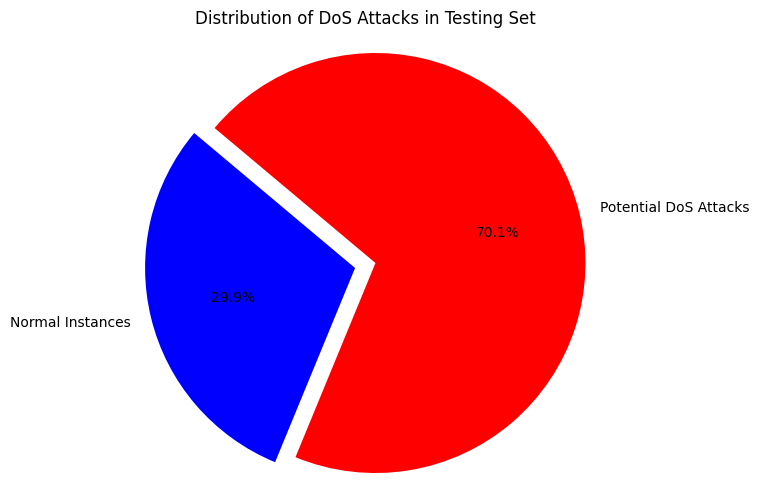

In [ ]:
import matplotlib.pyplot as plt

# Calculate the percentage of DoS attacks based on the testing set
total_instances = len(y_test)
dos_percentage = np.sum(y_test) / total_instances * 100
normal_percentage = 100 - dos_percentage

# Pie chart for the distribution of DoS attacks in the testing set
labels = ['Normal Instances', 'Potential DoS Attacks']
sizes = [normal_percentage, dos_percentage]
colors = ['blue', 'red']  # Using a contrasting color for DoS attacks
explode = (0, 0.1)  # Explode the 2nd slice (i.e., 'Potential DoS Attacks') to show clear distinction

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of DoS Attacks in Testing Set')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


Number of potential DoS attacks: 18480
Sample of potential DoS attacks:
            Id              IP   bot  FunctionId functionTrigger  \
113471  113471  223.113.21.186  True          23             sql   
113472  113472  223.113.21.186  True          23             sql   
113473  113473  223.113.21.186  True          23             sql   
113474  113474  223.113.21.186  True          23             sql   
113475  113475  223.113.21.186  True          23             sql   

                       timestamp  SubmitTime       RTT  InvocationDelay  \
113471  2022-01-02T03:53:06.751Z          76  0.669502         0.671971   
113472  2022-01-02T03:53:15.085Z          76  0.669502         0.671971   
113473  2022-01-02T03:53:20.163Z          76  0.669502         0.671971   
113474  2022-01-02T03:53:26.700Z          76  0.669502         0.671971   
113475  2022-01-02T03:53:33.788Z          76  0.669502         0.671971   

        ResponseDelay  ...  InvocationDelay_entropy  ResponseDelay_e

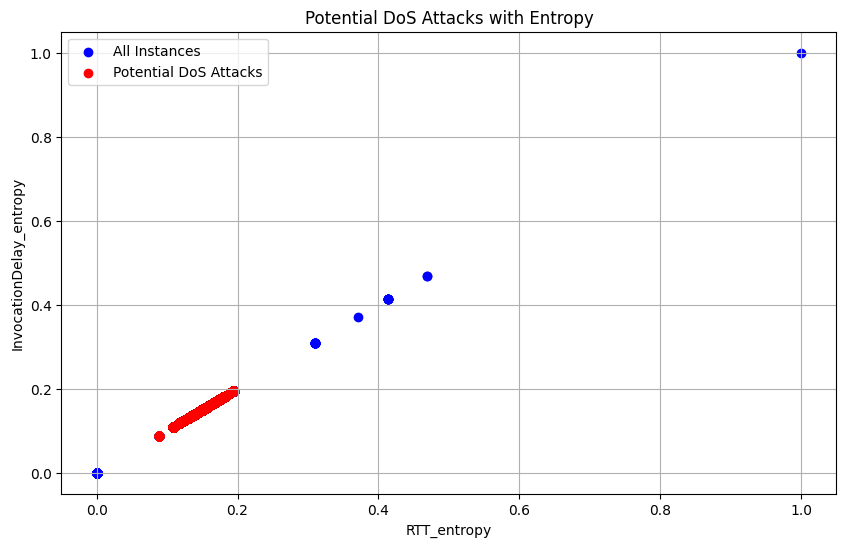

In [ ]:
# Get the indices of the testing set
test_indices = np.arange(len(X_train), len(X_train) + len(X_test))

# Filter df to include only samples from the testing set
df_test = df.iloc[test_indices]

# Define entropy threshold
entropy_threshold = -1.442695e-10  # Example threshold value

# Detect potential DoS attacks based on model predictions and entropy values
potential_dos_mask = (
    (y_pred_binary_flat == 1) &
    (df_test['RTT_entropy'] > entropy_threshold) &
    (df_test['InvocationDelay_entropy'] > entropy_threshold) &
    (df_test['ResponseDelay_entropy'] > entropy_threshold) &
    (df_test['FunctionDuration_entropy'] > entropy_threshold) &
    (df_test['ActiveFunctionsAtRequest_entropy'] > entropy_threshold) &
    (df_test['ActiveFunctionsAtResponse_entropy'] > entropy_threshold) &
    (df_test['maxcpu_entropy'] > entropy_threshold) &
    (df_test['avgcpu_entropy'] > entropy_threshold) &
    (df_test['p95maxcpu_entropy'] > entropy_threshold) &
    (df_test['vmcorecountbucket_entropy'] > entropy_threshold) &
    (df_test['vmmemorybucket_entropy'] > entropy_threshold)
)

# Print the number of potential DoS attacks identified
print("Number of potential DoS attacks:", np.sum(potential_dos_mask))

# Inspect a sample of the DataFrame to ensure the filtering is correct
print("Sample of potential DoS attacks:")
print(df_test[potential_dos_mask].head())

# Choose two entropy features for visualization
entropy_feature1 = 'RTT_entropy'
entropy_feature2 = 'InvocationDelay_entropy'

# Plot potential DoS attacks with corresponding entropy values
plt.figure(figsize=(10, 6))
plt.scatter(df_test[entropy_feature1], df_test[entropy_feature2], c='blue', label='All Instances')
plt.scatter(df_test[potential_dos_mask][entropy_feature1], df_test[potential_dos_mask][entropy_feature2], c='red', label='Potential DoS Attacks')
plt.xlabel(entropy_feature1)
plt.ylabel(entropy_feature2)
plt.title('Potential DoS Attacks with Entropy')
plt.legend()
plt.grid(True)
plt.show()
